# Setup

In [1]:
from pprint import pprint
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

# Setup spark session
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.102:7077")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","100s")\
        .config("spark.sql.broadcastTimeout","600s")\
        .config("spark.executor.cores",2)\
        .config("spark.executor.memory",'4g')\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .appName("Analyse-1")\
        .getOrCreate()

# Old API (RDD)
spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")

22/03/17 08:50:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/17 08:50:07 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


# Import data

In [2]:
#Import data
data_frame = spark_session.read\
    .option("header", "true")\
    .csv('hdfs://192.168.2.102:9000/data_2021/*.csv')
data_frame.rdd.getNumPartitions()

157

In [3]:
#Remove unnecessary columns
column_filter = ["date","serial_number","model","failure","smart_9_raw"]
filtered_df = data_frame.select(*column_filter).cache()

# Number of drives

In [4]:
num_drives_by_date = filtered_df.groupBy("date").count().orderBy("date").collect()

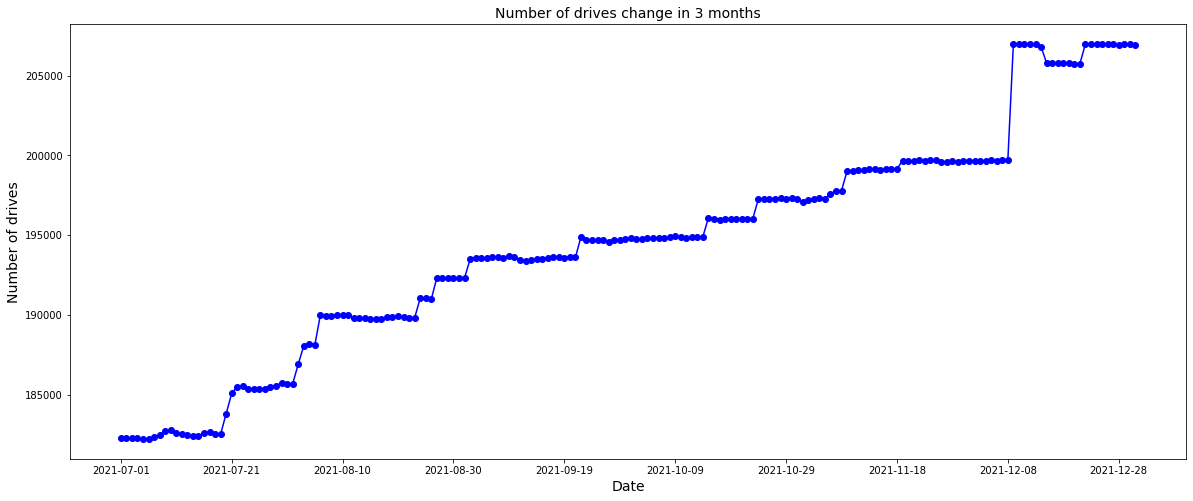

In [6]:
# Plot result
plt.figure(figsize=(20,8))
plt.plot([a[0] for a in num_drives_by_date], [a[1] for a in num_drives_by_date], color='blue', marker='o')
plt.title('Number of drives change in 3 months', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of drives', fontsize=14)
plt.xticks(range(0,len(num_drives_by_date),20))
plt.show()

# Failed drives

In [7]:
num_failures_by_date = filtered_df.filter(filtered_df["failure"] == 1).groupBy("date").count().collect()

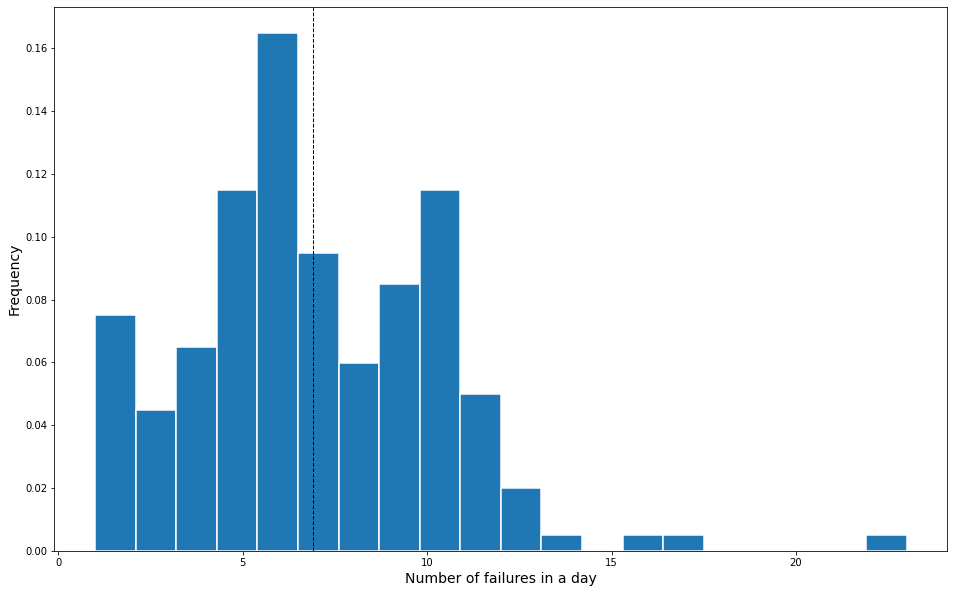

In [9]:
#Number of failures list
x = [a[1] for a in num_failures_by_date]

plt.figure(figsize=(16,10))
plt.hist(x, density=True, bins=20, edgecolor='white', linewidth=1.5)
plt.ylabel('Frequency',fontsize=14)
plt.xlabel('Number of failures in a day',fontsize=14);
plt.axvline(np.mean(np.array(x)), color='k', linestyle='dashed', linewidth=1)
plt.show()

# Drive models stats

In [10]:
#failures_by_model: ('Drive model','number of failed drives')
failures_by_model = filtered_df.filter(filtered_df["failure"] == 1).groupBy("model").count().withColumnRenamed("count","failure_count")

In [11]:
#model_count: ('Drive model', 'total number of unique drives spinning')
model_count = filtered_df.select("model","serial_number").distinct().groupBy("model").count()

In [12]:
#Joint table of failures_by_model and model_count
accu_count = model_count.join(failures_by_model,"model")
#Add failure rate column
accu_fail = accu_count.withColumn('failure_rate', accu_count['failure_count'].cast('float')/accu_count['count'].cast('float')*1000)

In [13]:
result = accu_fail.orderBy("failure_rate").take(10)

In [15]:
#Accumulated result presentation
print(tabulate(result, headers=["Drive model","Total drives","Failure count","Failure Rate (‰)"], tablefmt="grid", showindex="always"))

+----+----------------------+----------------+-----------------+--------------------+
|    | Drive model          |   Total drives |   Failure count |   Failure Rate (‰) |
+====+======================+================+=================+====================+
|  0 | WDC WUH721816ALE6L0  |           1768 |               1 |           0.565611 |
+----+----------------------+----------------+-----------------+--------------------+
|  1 | HGST HUH721212ALE600 |           2602 |               2 |           0.76864  |
+----+----------------------+----------------+-----------------+--------------------+
|  2 | ST6000DX000          |            887 |               1 |           1.1274   |
+----+----------------------+----------------+-----------------+--------------------+
|  3 | HGST HMS5C4040BLE640 |          12748 |              15 |           1.17666  |
+----+----------------------+----------------+-----------------+--------------------+
|  4 | HGST HUH721212ALE604 |          13155 |        

# Failure and time on power

In [16]:
#time_on_before_failed: amount of running time (in hours) of failed drives
time_on_before_failed = filtered_df.filter(filtered_df["failure"] == 1).select("smart_9_raw").collect()

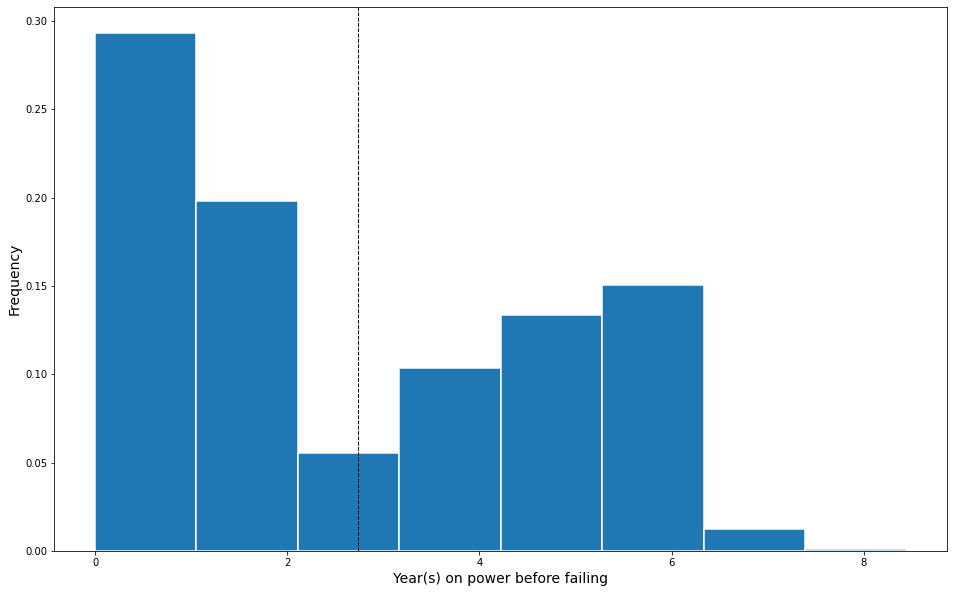

In [17]:
# Remove None value (where S.M.A.R.T attribute is not recorded/available) and convert unit to year
processed_time_on_before_failed = [float(a[0])/(365*24) for a in time_on_before_failed if a[0]] 

plt.figure(figsize=(16,10))
plt.hist(processed_time_on_before_failed, density=True, bins=8, edgecolor='white', linewidth=1.5)
plt.ylabel('Frequency',fontsize=14)
plt.xlabel('Year(s) on power before failing',fontsize=14);
plt.axvline(np.mean(np.array(processed_time_on_before_failed)), color='k', linestyle='dashed', linewidth=1)
plt.show()

# Finish

In [18]:
spark_session.stop()